In [1]:
import numpy as np

In [17]:
# Load cyst phantom scatterer data

import scipy.io as spio

file = r'C:\Users\spenc\Desktop\Experiments\ftp_files\cyst_phantom\pht_data.mat'
mat = spio.loadmat (file)

pos, amp = mat['phantom_positions'], mat['phantom_amplitudes']
scatterers = np.concatenate ([pos, amp], axis=-1)

print (scatterers.shape, scatterers.dtype)
print (scatterers)

(100000, 4) float64
[[ 1.57361843e-02 -2.22605310e-03  5.98219976e-02  1.67691480e+00]
 [ 2.02895969e-02  1.22839056e-03  5.56036884e-02  1.42544227e+00]
 [-1.86506592e-02 -4.63506804e-04  4.39676885e-02  7.94621465e-02]
 ...
 [-1.50000000e-02  0.00000000e+00  7.00000000e-02  2.00000000e+01]
 [-1.50000000e-02  0.00000000e+00  8.00000000e-02  2.00000000e+01]
 [-1.50000000e-02  0.00000000e+00  9.00000000e-02  2.00000000e+01]]


In [18]:
# Generate the transducer apertures for send and receive

f0 = 3.5e6                 #  Transducer center frequency [Hz]
fs = 100e6                 #  Sampling frequency [Hz]
c = 1540                   #  Speed of sound [m/s]
lambd = c / f0             #  Wavelength [m]
width = lambd              #  Width of element
height = 5 / 1000          #  Height of element [m]
kerf = 0.05 / 1000         #  Kerf (gap between elements) [m]
N_elements = 192           #  Number of physical elements
no_sub_x = 1               #  Number of sub-divisions in x-direction of elements
no_sub_y = 10              #  Number of sub-divisions in y-direction of elements

In [19]:
# Create and configure GPU simulator

from pyrfsim import RfSimulator

sim = RfSimulator ('gpu')
sim.set_print_debug (True)

sim.set_parameter ('sound_speed', str (c))
sim.set_parameter ('radial_decimation', '10') # depth-direction downsampling factor
sim.set_parameter ('phase_delay', 'on') # improves subsample accuracy

In [20]:
def subdivide (length, num):
    delta = length * 1/num
    divisions = np.arange ((-num//2 + 1) * delta, (num//2 + 1) * delta, delta)
    
    return divisions

def linear_transducer (N_elements, width, height, kerf, no_sub_x=1, no_sub_y=1, as_array=False):
    '''Calculates the origin positions of the (sub-)elements in a linear array transducer.'''
    
    elem_x = subdivide (width, no_sub_x)
    elem_y = subdivide (height, no_sub_y)
    
    template_x = np.tile (elem_x, [1, N_elements])
    template_x = template_x.repeat (no_sub_y, axis=0)
    template_y = np.tile (elem_y.reshape(-1, 1), [1, N_elements])
    template_y = template_y.repeat (no_sub_x, axis=1)
    
    pitch = (width + kerf) / 2 # element center-to-center distance
    origins_x = np.arange ((-N_elements//2 + 1) * pitch, (N_elements//2 + 1) * pitch, pitch).reshape (1, -1)
    origins_x = origins_x.repeat (no_sub_x, axis=1)
    origins_x = origins_x.repeat (no_sub_y, axis=0)
    
    transducer_x = template_x + origins_x
    transducer_y = template_y
    transducer_z = np.zeros (transducer_x.shape)
    
    if as_array:
        return np.stack ([transducer_x, transducer_y, transducer_z], axis=2)
    else:
        return {'x': transducer_x, 'y': transducer_y, 'z': transducer_z}

In [22]:
# Define a scan sequence

receive_aperture = linear_transducer (N_elements, width, height, kerf, no_sub_x, no_sub_y, as_array=True)

origins = receive_aperture.reshape (-1, 3).astype ('float32')
N_subelements = origins.shape[0]
directions = np.tile (np.array ([0, 0, 1], dtype='float32'), [N_subelements, 1])
lateral_dirs = np.tile (np.array ([1, 0, 0], dtype='float32'), [N_subelements, 1])
timestamps = np.zeros (N_subelements, dtype='float32')
line_length = .09

sim.set_scan_sequence (origins, directions, line_length, lateral_dirs, timestamps)

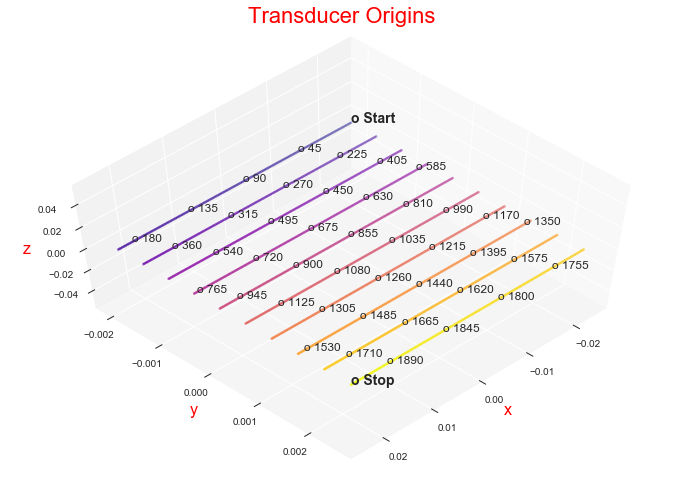

In [54]:
# Plot transducer origins

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,8))
ax = fig.gca(projection='3d')
ax.scatter (origins[:,0], origins[:,1], origins[:,2], c=np.arange (origins.shape[0]), s=5, cmap='plasma')

ax.text (*origins[0], 'o Start', fontsize=14, weight='bold')
for i in range (45, origins.shape[0], 45):
    ax.text (*origins[i], 'o {}'.format (i), fontsize=12, weight='ultralight')
ax.text (*origins[-1], 'o Stop', fontsize=14, weight='bold')

ax.set_xlabel ('x', color='red', fontsize=16, labelpad=10)
ax.set_ylabel ('y', color='red', fontsize=16, labelpad=10)
ax.set_zlabel ('z', color='red', fontsize=16, labelpad=10)
ax.set_title ('Transducer Origins', color='red', fontsize=22, pad=50)
ax.set_facecolor ('white')
ax.view_init (elev=60, azim=45)

plt.show()

In [ ]:
# Define excitation signal

from scipy.signal import gausspulse
import matplotlib.pyplot as plt

t = np.arange (-16/f0, 16/f0, 1/fs)
samples, envelope  = gausspulse(t, fc=f0, bw=.5, retenv=True)
samples = samples.astype ('float32')
center_index = len (t) // 2

plt.plot(t, envelope, 'g--', t, samples)
plt.title ('Excitation', fontsize=16, y=-.15)
plt.gca ().set_facecolor ('white')
plt.xticks ([])
plt.yticks ([])
plt.show ()

sim.set_excitation (samples, center_index, fs, f0)

In [43]:
x_range = scatterers[:,0].min (), scatterers[:,0].max ()
y_range = scatterers[:,1].min (), scatterers[:,1].max ()
z_range = scatterers[:,2].min (), scatterers[:,2].max ()
a_range = scatterers[:,3].min (), scatterers[:,3].max ()
print ('x:', x_range)
print ('y:', y_range)
print ('z:', z_range)
print ('a:', a_range)

x: (-0.02499944963292319, 0.02499881128465837)
y: (-0.00499989145765463, 0.0049999468013817395)
z: (0.030000373507137093, 0.09)
a: (-38.72031038564732, 32.009781862782376)


In [44]:
# Set scatterers

sim.clear_fixed_scatterers () # Make this cell idempotent

# transmit_aperture = linear_transducer (N_elements, width, height, kerf, no_sub_x, no_sub_y, as_array=True)
data = scatterers.astype ('float32')

sim.add_fixed_scatterers (data)

In [45]:
# Set the beam profile

sigma_lateral = 1e-3
sigma_elevational = 1e-3
sim.set_analytical_beam_profile (sigma_lateral, sigma_elevational)

In [46]:
# Simulate all scanlines

iq_lines = sim.simulate_lines ()

In [51]:
abs (iq_lines[500, center_index-10:center_index+10])

array([1.458588  , 1.6557018 , 1.6952932 , 1.5914077 , 1.3225027 ,
       1.107058  , 1.1391373 , 1.2628908 , 1.3718419 , 1.3316954 ,
       1.137824  , 0.90261763, 0.6483936 , 0.35307804, 0.2033428 ,
       0.38519943, 0.66117054, 0.88369364, 1.1811124 , 1.6057206 ],
      dtype=float32)

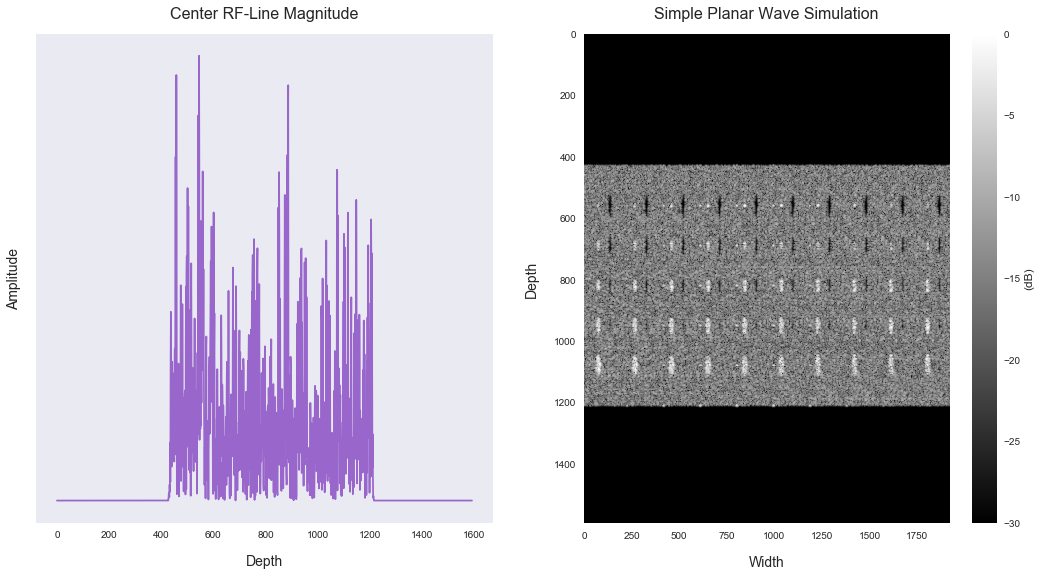

In [52]:
# Plot results

from visualize import *

title = 'Simple Planar Wave Simulation'
visualize (iq_lines, title, figsize=(18, 9), min_dB=-30)